## Load a SimpleActiveLearningJob from disk

Use ``load_external`` to load the job from the previous Jupyter Notebook tutorial. Make sure to provide the correct path!

In [2]:
from scm.simple_active_learning import SimpleActiveLearningJob
import scm.plams as plams
import matplotlib.pyplot as plt
import os

In [3]:
# replace the path with your own path !
previous_sal_job_path = os.path.expandvars("$AMSHOME/examples/SAL/Output/SingleMolecule/plams_workdir/sal")
job = SimpleActiveLearningJob.load_external(previous_sal_job_path)

## Access the log file

The results of the active learning are printed in a human-friendly format in the log file. For example, let's print the last few lines:

In [4]:
n_lines = 40
end_of_logfile = "\n".join(job.results.read_file("simple_active_learning.log").split("\n")[-n_lines:])
print(end_of_logfile)

[31.01|17:55:16] 
[31.01|17:55:16] Current (cumulative) timings:
[31.01|17:55:16]                                           Time (s) Fraction
[31.01|17:55:16]     Ref. calcs                               20.44    0.034
[31.01|17:55:16]     ML training                             365.82    0.608
[31.01|17:55:16]     Simulations                             215.21    0.358
[31.01|17:55:16] 
[31.01|17:55:16] 
[31.01|17:55:16] Step 5 finished successfully!
[31.01|17:55:16] 
[31.01|17:55:16] --- Begin summary ---
[31.01|17:55:16] Step  Attempt Status   Reason      finalframe_forces_max_delta
[31.01|17:55:16]     1      1 FAILED   Inaccurate                  1.7423
[31.01|17:55:16]     1      2 SUCCESS  Accurate                    0.5734
[31.01|17:55:16]     2      1 FAILED   Inaccurate                  1.0679
[31.01|17:55:16]     2      2 SUCCESS  Accurate                    0.3920
[31.01|17:55:16]     3      1 FAILED   Inaccurate                  0.9762
[31.01|17:55:16]     3      2 FAILED 

Above we can easily see that there were 5 active learning steps, and the engine settings for the final trained ML potential.

Tip: You can copy-paste the lines from ``Engine MLPotential`` to ``EndEngine`` into AMSinput to use those engine settings for other production simulations in the GUI.

## Access the MD trajectories

By default, the ``ActiveLearning%AtEnd%RerunSimulation`` option is enabled. This means that after the active learning loop has finished, the entire simulation is rerun from scratch with the final set of parameters.

There are thus two trajectories:

* A trajectory run only with the final parameters, and that is just a normal AMS job. This trajectory is located in the directory ``final_production_simulation`` if it exists.

* A trajectory where the parameters have been updated on-the-fly, and which may also have an inconsistent MD sampling frequency. This trajectory is located in one of the ``stepX_attemptY_simulation`` directories.

Use the ``get_simulation_directory`` method to get the corresponding directories.

Let's start with the **final production simulation**:

In [5]:
final_production_simulation_dir = job.results.get_simulation_directory(allow_final=True)
print(final_production_simulation_dir)

/home/hellstrom/adfhome/scripting/scm/simple_active_learning/examples/Output/SingleMolecule/plams_workdir/sal/final_production_simulation


View the trajectory in AMSmovie:

In [6]:
final_job = plams.AMSJob.load_external(final_production_simulation_dir)
final_rkf = final_job.results.rkfpath()

In [7]:
!amsmovie {final_rkf}

Let's then get the **other (with on-the-fly-updated-engine) trajectory**: 

In [8]:
onthefly_simulation_dir = job.results.get_simulation_directory(allow_final=False)
print(onthefly_simulation_dir)

/home/hellstrom/adfhome/scripting/scm/simple_active_learning/examples/Output/SingleMolecule/plams_workdir/sal/step5_attempt1_simulation


In [9]:
onthefly_job = plams.AMSJob.load_external(onthefly_simulation_dir)
onthefly_rkf = onthefly_job.results.rkfpath()

In [10]:
!amsmovie {onthefly_rkf}

Let's compare energy-vs-frame for the two trajectories:

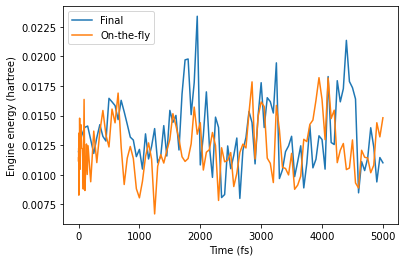

In [11]:
plt.plot(
    final_job.results.get_history_property("Time", "MDHistory"),
    final_job.results.get_history_property("EngineEnergy"),
)
plt.plot(
    onthefly_job.results.get_history_property("Time", "MDHistory"),
    onthefly_job.results.get_history_property("EngineEnergy"),
)
plt.legend(["Final", "On-the-fly"])
plt.xlabel("Time (fs)")
plt.ylabel("Engine energy (hartree)");

The energy profiles look quite similar. For the on-the-fly trajectory, there are more datapoints for short times since the Simple Active Learning tool samples more frequently in the beginning of the simulation when there are only a few MD steps per active learning step.

## Access the ParAMS training results

Similarly to the final production trajectory, there is an input option ``ActiveLearning%AtEnd%RetrainModel`` which will retrain the model at the end, guaranteeing that all the generated reference data is used during the training or validation. However, this option is off by default.

The method ``get_params_results_directory()`` returns the ParAMS results directory, which can be
* used as the value for ``MachineLearning%LoadModel`` to continue with another active learning run, or
* opened in the ParAMS GUI to view all results, including loss function minimization and predicted-vs-reference scatter plots

The method ``get_params_job()`` returns a ``ParAMSJob`` whose results can directly be accessed using the normal ``ParAMSJob`` and ``ParAMSResults`` python APIs.

In [12]:
params_results_dir = job.results.get_params_results_directory(allow_final=True)
print(params_results_dir)

/home/hellstrom/adfhome/scripting/scm/simple_active_learning/examples/Output/SingleMolecule/plams_workdir/sal/step4_attempt1_training/results


**Open it in the ParAMS GUI**:

In [13]:
!params -gui "{params_results_dir}"

The ParAMS GUI is the best way to quickly get an overview of the data sets and results.

However, it can also be useful to **access results from Python**. 

The details of the ParAMSJob and ParAMSResults classes are shown in the ParAMS Python examples, here we just provide a quick example:

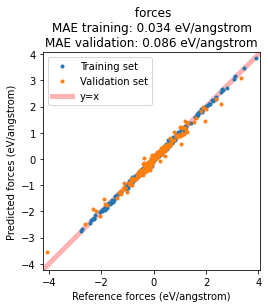

In [14]:
params_job = job.results.get_params_job()
params_job.results.plot_simple_correlation("forces", source="best");

If you want to access individual data entries or the MAE in Python, you can use the ``params_job.results.get_data_set_evaluator()`` method. See the ParAMS DataSetEvaluator documentation for details.

## Access the production engine settings

The engine settings used for production simulation can be accessed from the ParAMS job:

In [15]:
engine_settings = params_job.results.get_production_engine_settings()
print(plams.AMSJob(settings=engine_settings).get_input())

Engine MLPotential
  Backend M3GNet
  MLDistanceUnit angstrom
  MLEnergyUnit eV
  Model Custom
  ParameterDir /home/hellstrom/adfhome/scripting/scm/simple_active_learning/examples/Output/SingleMolecule/plams_workdir/sal/step4_attempt1_training/results/optimization/m3gnet/m3gnet
EndEngine




## Access the reference data

The ``stepX_attemptY_reference_data`` directories can be accessed using ``get_reference_data_directory()``:

In [16]:
ref_dir = job.results.get_reference_data_directory()
print(ref_dir)

/home/hellstrom/adfhome/scripting/scm/simple_active_learning/examples/Output/SingleMolecule/plams_workdir/sal/step5_attempt1_reference_data
